## <a id="Top" style="color:black;">Top</a>
- [Plotting BH evaporation](#BHevap)
- [Fitting the Lightcurves of GRB candidates](#lightcurves)
- [Expanding to other sources](#candidates)
- [Batch fit all sources with a GBM or LLE t90 less than 2s](#batchfit2s)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, norm
import pandas as pd

# For threeML lightcurves & fitting.

from threeML import *

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

from threeML.io.package_data import get_path_of_data_file

import warnings
warnings.simplefilter("ignore")

### <a id="BHevap" style="color:black;">Plotting BH evaporation</a>
[back to top](#Top)

In [3]:
#GBM Energy Spectrum
Emin = 50*10**(-6) # GeV
Emax = 300*10**(-6) # GeV


def afterglow(tau, delta, t_m, t_p, normalization):
    # lifetime only, no spectrum.
    # Norm * \frac{e^{(-t -\Delta)/tp } }{1 - e^{(-t - \Delta)/tm} }
    return normalization*np.exp(-(1/t_p)*(tau-delta))/(1 + np.exp(-(1/t_m)*(tau-delta)))

# Simplifying lightcurve with powerlaw of index -.52
def lightcurve(tau, energy_range, normalization = 1., index = .52):
    return normalization*tau**(-index)

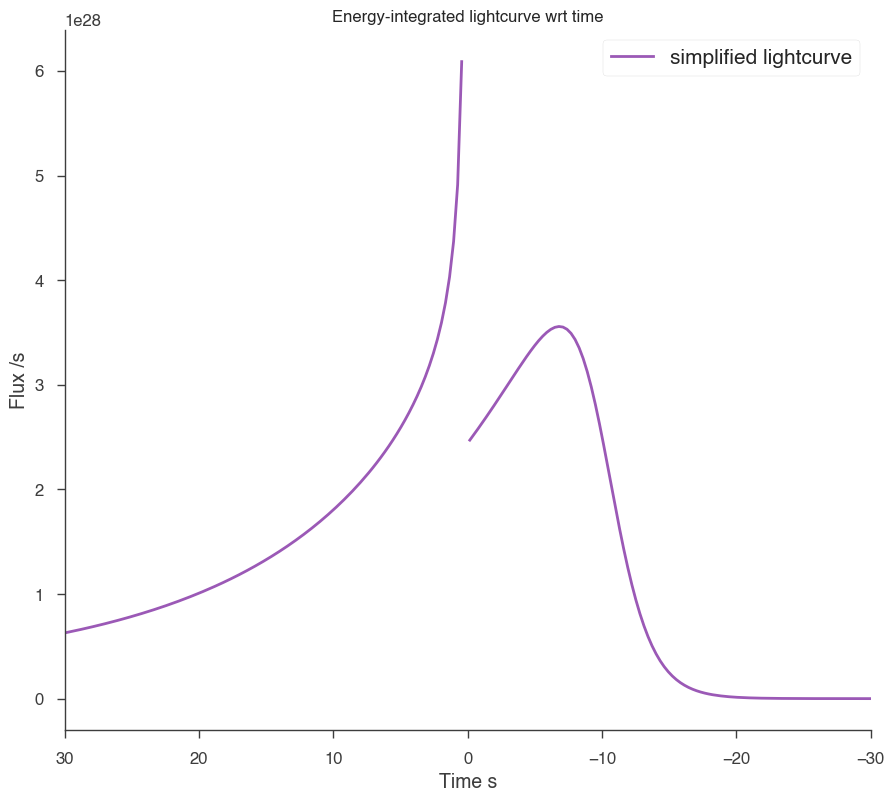

In [4]:
tau_s = np.linspace(30,0,100)
tau_a = np.linspace(30,-30,200)

s_curve = np.zeros(200)

fig, ax = plt.subplots()

s_curve[0:100] = lightcurve(tau_s,energy_range = np.linspace(Emin, Emax, 1000), normalization = 2*1e28)

a_curve = afterglow(tau_a, -10, 1.5, 14, 5*1e28)

ax.plot(tau_a, s_curve + a_curve, label = 'simplified lightcurve')

ax.set_xlim(30,-30)

ax.set_xlabel("Time s")
ax.set_ylabel("Flux /s")
ax.set_title("Energy-integrated lightcurve wrt time")
ax.legend(prop={'size':15})
plt.show()

### <a id="lightcurves" style="color:black;">Fitting the Lightcurves</a>
[back to top](#Top)

In [5]:
gbm_catalog = FermiGBMBurstCatalog()

In [47]:
def query_catalog(GRBNAME = '150902733', time_in = -30, time_out = 60, dt = .1, gbm_detectors = None):
    gbm_catalog.query_sources('GRB%s'%GRBNAME)

    grb_info = gbm_catalog.get_detector_information()['GRB%s'%GRBNAME]
    
    if gbm_detectors is None:
        gbm_detectors = grb_info["detectors"]
    print(gbm_detectors)
    source_interval = grb_info["source"]["fluence"]
    background_interval = grb_info["background"]["full"]
    dload = download_GBM_trigger_data('bn%s'%GRBNAME, detectors=gbm_detectors)

    fluence_plugins = []
    time_series = {}
    figures = []
    for det in gbm_detectors:

        ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
            det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
        )

        ts_cspec.set_background_interval(*background_interval.split(","))
        ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

        ts_tte = TimeSeriesBuilder.from_gbm_tte(
            det,
            tte_file=dload[det]["tte"],
            rsp_file=dload[det]["rsp"],
            restore_background=f"{det}_bkg.h5",
        )

        time_series[det] = ts_tte

        ts_tte.set_active_time_interval(source_interval)

        figures.append(ts_tte.view_lightcurve(time_in, time_out, dt = dt))
    return figures, gbm_detectors

import warnings
warnings.filterwarnings('ignore')

def get_curves(fig):
    data = fig.get_axes()[0].get_lines()[0].get_xydata()
    x = data[:,0]
    curve = data[:,1]
    
    bckg_data = fig.get_axes()[0].get_lines()[1].get_xydata()
    bckg_data = bckg_data[:,1]
    
    return x, curve, bckg_data

def show_curves(figures, detectors:list = np.arange(12), save_csv=None):
    figya, ax = plt.subplots()
    if save_csv is not None:
        assert type(save_csv) is str, 'Give a name to the file'
        assert detectors is not None, 'Just gimme the dets for cols'
        df = pd.DataFrame()
    for i,fig in enumerate(figures):
        x,curve, bckg = get_curves(fig)
        ax.plot(x,curve, label="det. %s"%detectors[i])
        ax.plot(x[0:-1],bckg, '--', label='bckg %s'%detectors[i])
        ax.legend(prop={'size':15})
        if save_csv is not None:
            df['time'] = x
            df[detectors[i]] = curve
            b = np.zeros(len(curve))
            b[0:len(bckg)] += bckg
            df['%s_bkg'%detectors[i]] = b
    if save_csv is not None:
        df.to_csv(save_csv)
    return figya

['n0' 'n1' 'n3' 'b0']


17:24:15 INFO      file glg_cspec_n0_bn150902733_v00.pha is already downloaded!           ]8;id=429767;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=48904;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n0_bn150902733_v02.rsp is already downloaded!           ]8;id=240618;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=227743;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

17:24:16 INFO      file glg_tte_n0_bn150902733_v00.fit is already downloaded!             ]8;id=572611;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=46283;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n1_bn150902733_v00.pha is already downloaded!           ]8;id=237694;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=540666;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

17:24:17 INFO      file glg_cspec_n1_bn150902733_v02.rsp is already downloaded!           ]8;id=852432;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=244608;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n1_bn150902733_v00.fit is already downloaded!             ]8;id=818646;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=380906;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n3_bn150902733_v00.pha is already downloaded!           ]8;id=185590;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=560293;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

17:24:18 INFO      file glg_cspec_n3_bn150902733_v02.rsp is already downloaded!           ]8;id=227756;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=919003;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n3_bn150902733_v00.fit is already downloaded!             ]8;id=960001;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=114438;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

17:24:19 INFO      file glg_cspec_b0_bn150902733_v00.pha is already downloaded!           ]8;id=147223;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=359462;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_b0_bn150902733_v02.rsp is already downloaded!           ]8;id=986267;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=98109;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

17:24:20 INFO      file glg_tte_b0_bn150902733_v00.fit is already downloaded!             ]8;id=525841;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=474491;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

17:24:23 INFO      Auto-determined polynomial order: 1                                ]8;id=861963;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=12608;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

17:24:41 INFO      None 1-order polynomial fit with the mle method                               ]8;id=55954;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=804787;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n0_bkg.h5                                         ]8;id=569718;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=40661;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n0_bkg.h5                                         ]8;id=603841;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=266076;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n0_bkg.h5                              ]8;id=546664;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=430221;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 3.84-17.408 for n0                                    ]8;id=399135;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=182085;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

17:24:46 INFO      Auto-determined polynomial order: 1                                ]8;id=7327;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=825510;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

17:24:59 INFO      None 1-order polynomial fit with the mle method                               ]8;id=993217;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=740572;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n1_bkg.h5                                         ]8;id=653042;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=383265;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n1_bkg.h5                                         ]8;id=640460;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=275265;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n1_bkg.h5                              ]8;id=565177;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=609433;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

17:25:00 INFO      Interval set to 3.84-17.408 for n1                                    ]8;id=417068;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=837161;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

17:25:04 INFO      Auto-determined polynomial order: 1                                ]8;id=48280;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=443961;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_03 background:   0%|                    | 0/128 [00:00<?, ?it/s]

17:25:14 INFO      None 1-order polynomial fit with the mle method                               ]8;id=564516;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=913045;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=352247;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=28589;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=30326;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=686906;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

17:25:15 INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=265705;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=804134;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 3.84-17.408 for n3                                    ]8;id=807124;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=12358;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

17:25:19 INFO      Auto-determined polynomial order: 1                                ]8;id=537052;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=824418;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

17:25:30 INFO      None 1-order polynomial fit with the mle method                               ]8;id=864416;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=135650;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=376228;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=801415;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=716354;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=209563;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

17:25:31 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=709973;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=103055;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 3.84-17.408 for b0                                    ]8;id=495258;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=972401;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Maximum 8693.350706461864 at index 392, time 9.2
Maximum 8321.464903356951 at index 392, time 9.2
Maximum 9368.182837570457 at index 392, time 9.2
Maximum 7508.1787332614285 at index 392, time 9.2


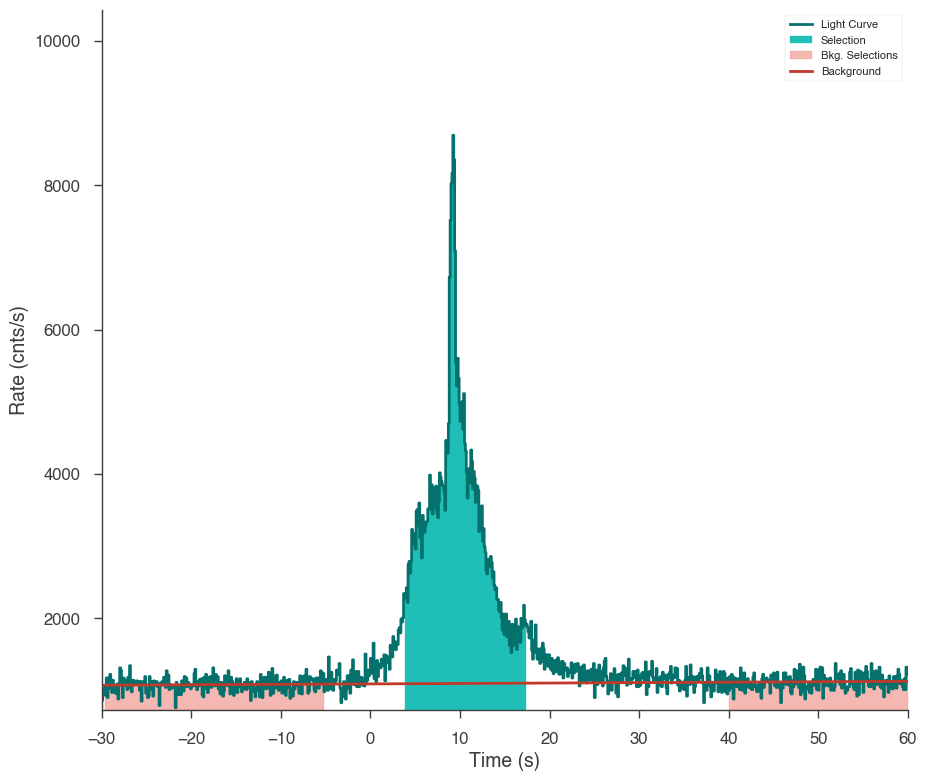

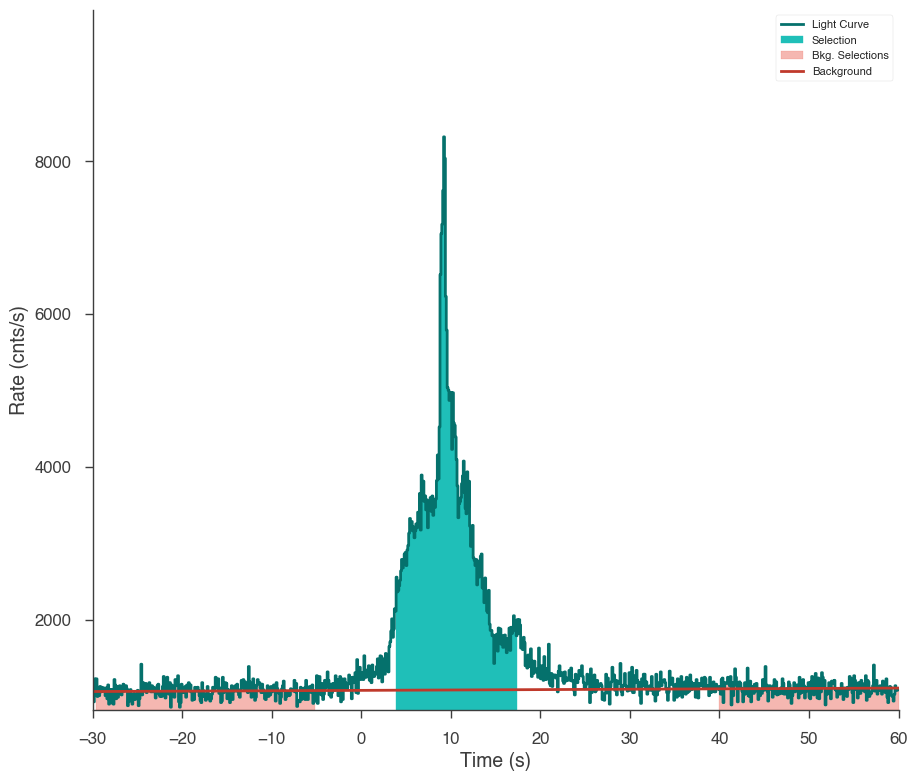

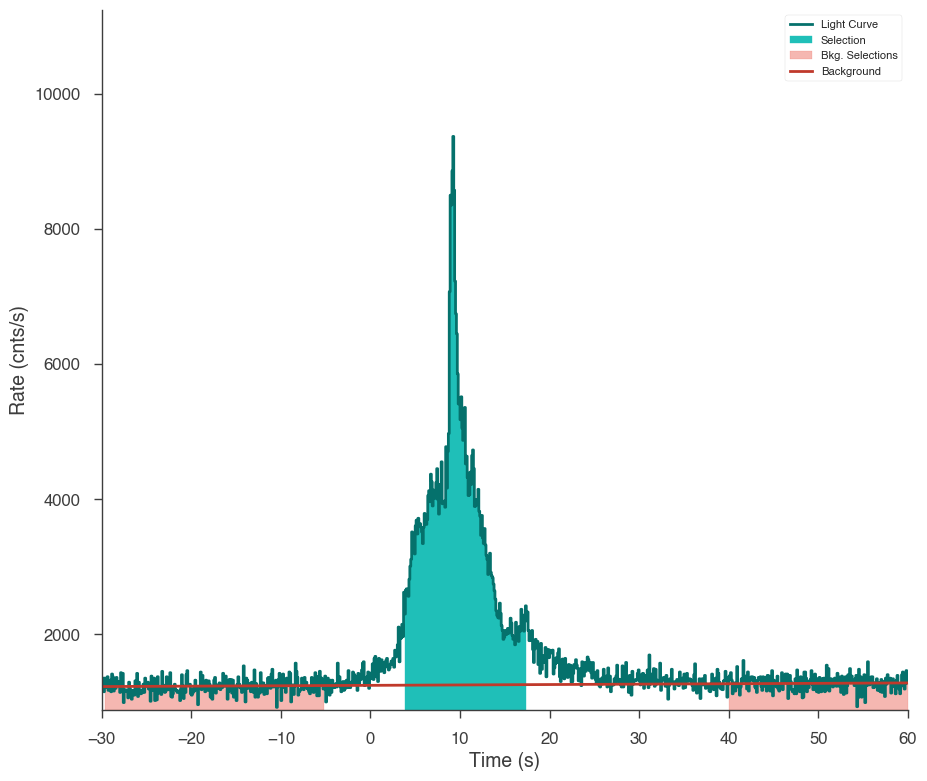

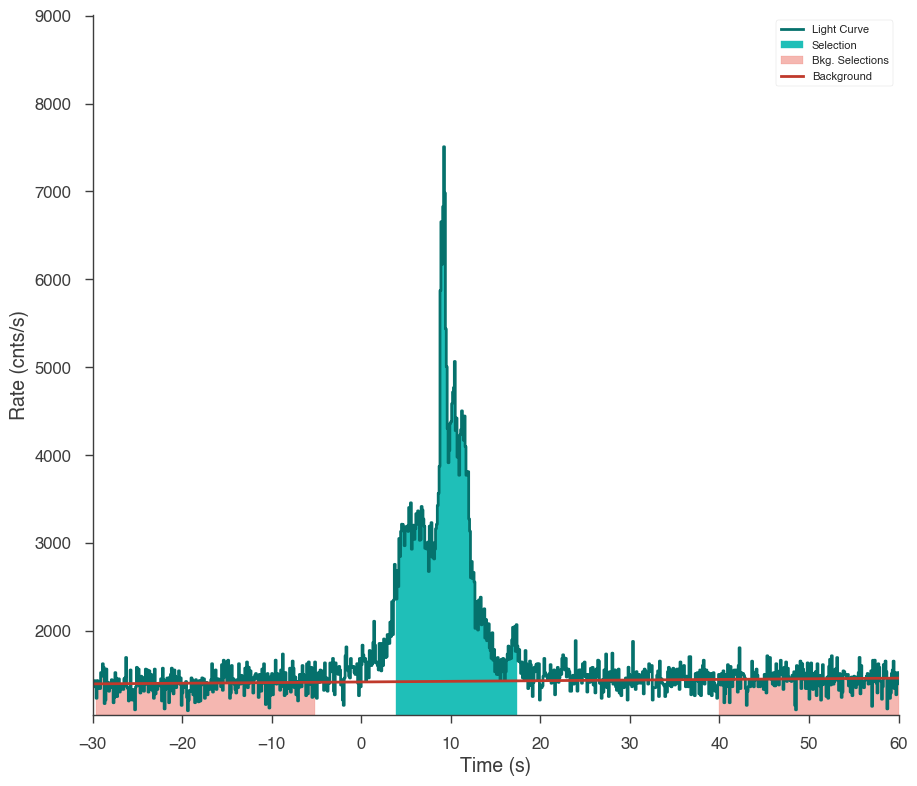

In [17]:
figures,dets = query_catalog(dt=.1)

"""
y = []
for fig in figures:
    x, curve, _ = get_curves(fig)
    print("Maximum %s at index %s, time %s"%(max(curve), 
                                             np.where(curve == max(curve))[0][0], 
                                             x[np.where(curve == max(curve))[0][0]]))
    y.append(curve)
"""

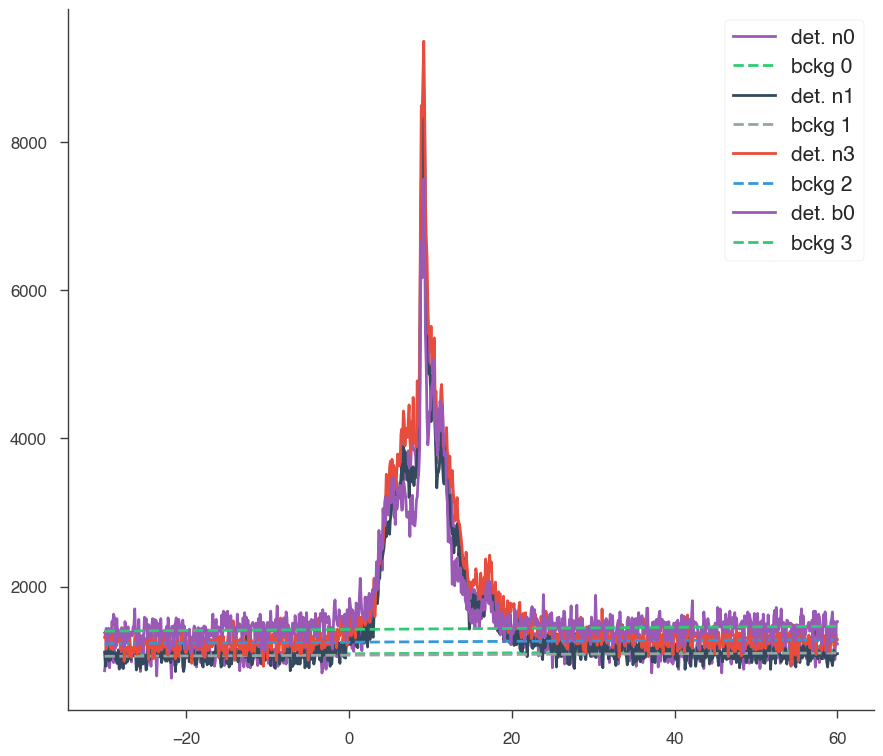

In [19]:
fig = show_curves(figures,dets)
fig.show()

In [53]:
def detector_data_to_DataFrame(figures, GRBNAME):
    
    gbm_catalog.query_sources('GRB%s'%GRBNAME)
    grb_info = gbm_catalog.get_detector_information()['GRB%s'%GRBNAME]
    gbm_detectors = grb_info["detectors"]
    
    
    t = ['tau_' + item for item in gbm_detectors]
    bckg = [item + '_bckg' for item in gbm_detectors]
    
    data = pd.DataFrame()
        
    for i,fig in enumerate(figures):
        x, curve, bckg_data = get_curves(fig)
        
        data[t[i]]=pd.Series(x)
        data[gbm_detectors[i]] = pd.Series(curve)
        data[bckg[i]] = pd.Series(bckg_data)
    print('Saving to bn%s.csv'%GRBNAME)
    data.to_csv('bn%s.csv'%GRBNAME)
    
def retrieve_data(figures):
    y = None
    for fig in figures:
        x, curve, bckg_data = get_curves(fig)
        if y is None:
            y = curve-np.mean(bckg_data)
        else:
            y+=(curve-np.mean(bckg_data))
    return y/len(figures), x

Building our model to fit the lightcurve requires a couple components.

Firstly, the model needs to have one value per second interval to match the lightcurves. This will occupy the interval of the signal onset.

Second, we will want an afterglow ~ inverse powerlaw. This will be the interval following, showing the decay of the signal. We could start this decay from the maximum from the previous interval, but I think it's better to leave it open for now.
[Afterglow]()

Lastly there will be a background which contributes to the model evenly.

In [9]:
# Assemble the data
data, time_domain = retrieve_data(figures)
# This data is the curve averaged over detectors - background. All we need is the model.

# We want this to base the EBH lifetime.
peak_index = np.where(data == max(data))[0][0]
print('Peak index at %s'%peak_index)

# Data error 
error_tolerance = np.mean(data) * 0.001

In [55]:
import ultranest

param_names = ['K_lightcurve', 'K_powerlaw', 't_m_powerlaw', 't_p_powerlaw', 
               'delta_powerlaw', 'index_lightcurve'] 

def lightcurve_model(K_lightcurve=None, K_powerlaw=None, 
        t_m_powerlaw=None, t_p_powerlaw=None, 
                     delta_powerlaw=None, index_lightcurve=None,
                     energy_range = np.linspace(Emin, Emax, 1000)):
    
    # Blank model
    model = np.zeros(len(data))

    if K_lightcurve is not None:
        # Descending from len(peak) -> 0 
        tau = np.linspace(peak_index, 0, peak_index, endpoint=False)
        # Simplified powerlaw curve
        curve = lightcurve(tau=tau, energy_range=energy_range, normalization=K_lightcurve, index = index_lightcurve)
        # Applied to [0,peak]
        model[0:peak_index]=curve
    
    if K_powerlaw is not None: 
        # Afterglow curve
        afterglow_curve = afterglow(tau=time_domain, delta = delta_powerlaw, t_p = t_p_powerlaw, t_m = t_m_powerlaw, normalization=K_powerlaw)
        # Applied across entire domain
        model = model + afterglow_curve

    return model

def likelihood_model(params):
    K_lightcurve, K_powerlaw, t_m_powerlaw, t_p_powerlaw, delta_powerlaw, index_lightcurve = params
    
    curve = lightcurve_model(K_lightcurve, K_powerlaw, t_m_powerlaw, t_p_powerlaw, delta_powerlaw, index_lightcurve)
    
    like = -0.5 * (((curve - data)/error_tolerance)**2).sum()
    #like = pearsonr(data,curve)[0]
    return like

def likelihood_model_only_direct(params):
    K_lightcurve, index_lightcurve = params
    curve = lightcurve_model(K_lightcurve, None, None, None, None, index_lightcurve)
    return -0.5 * (((curve - data)/error_tolerance)**2).sum()
    
def likelihood_model_only_afterglow(params):
    K_powerlaw, t_m_powerlaw, t_p_powerlaw, delta_powerlaw = params
    curve = lightcurve_model(None, K_powerlaw, t_m_powerlaw, t_p_powerlaw, delta_powerlaw, None)
    return -0.5 * (((curve - data)/error_tolerance)**2).sum()

def prior_transform(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3#1e-26
    hi = 1e6#1e-24
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

In [47]:
# Run fitting process
sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_transform)

result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+08  2e+08 [-2.234e+08..-2.234e+08]*| it/evals=34200/459327 eff=7.4522% N=400 
[ultranest] Likelihood function evaluations: 459327
[ultranest]   logZ = -2.234e+08 +- 0.229
[ultranest] Effective samples strategy satisfied (ESS = 2505.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.59, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.23 tail:0.01 total:0.23 required:<0.50
[ultranest] done iterating.

logZ = -223374814.038 +- 0.392
  single instance: logZ = -223374814.038 +- 0.225
  bootstrapped   : logZ = -223374814.090 +- 0.392
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: 28219 iterations

    K_lightcurve        3374.28 +- 0.36
    K_powerlaw          7604.41 +- 0.15
    t_m_powerlaw        1.261831 +- 0.000034
    t_p_powerlaw        2.31333 +- 0.00014
    delta_powerlaw      9.6

In [56]:
def plot_model(x, result = None, log=False, name='bn150902733', vals=None, fig_text = None):
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_figwidth(18)
    
    if result is not None:
        vals = result['posterior']['mean']
        std = result['posterior']['stdev']
    K_lightcurve = vals[0]
    K_powerlaw = vals[1]
    t_m_powerlaw = vals[2]
    t_p_powerlaw = vals[3]
    delta_powerlaw = vals[4]
    index_lightcurve = vals[5]
    
    ax1.scatter(x,data, s=30)
    ax2.scatter(x,data, s=30)
    
    fitted_model = lightcurve_model(K_lightcurve, K_powerlaw, t_m_powerlaw, t_p_powerlaw, delta_powerlaw, index_lightcurve)
    r = pearsonr(data,fitted_model)
    ax1.plot(x, 
            fitted_model,
            label = 'r:%.4e  pval:%.4e'%(r[0],r[1]))
    
    if K_lightcurve is not None:
        curve = lightcurve(tau=np.linspace(peak_index, 0, peak_index, endpoint=False), 
                                  energy_range=np.linspace(Emin, Emax, 1000), 
                                  normalization=K_lightcurve)
        ax2.plot(x[0:peak_index], curve, label = 'simplified direct+frag emission')
    if K_powerlaw is not None:
        afterglow_curve = afterglow(tau=time_domain, delta = delta_powerlaw, t_p = t_p_powerlaw, t_m = t_m_powerlaw, normalization=K_powerlaw)
        ax2.plot(x, afterglow_curve, '--', label = r'afterglow $\frac{e^{Ax}}{1-e^{Bx}}$', color='orange')

    #plt.ylim(100,200)
    #ax2.ylim(-3500,6500)
    ax1.legend(prop={'size': 15})
    ax2.legend(prop={'size': 15})
    ax1.set_ylabel('Count rate (per second, binned on .1s)')
    ax1.set_xlabel('Time wrt to trigger time')
    #ax2.set_ylabel('Count rate')
    ax2.set_xlabel('Time wrt to trigger time')
    fig.suptitle('Composite Bayesian fit of %s'%name, size=15)
    
    if fig_text is None:
        lc_txt="Lightcurve norm: %.4e +- %.2e & index: %.4f +- %.2f ; \n"%(vals[0], std[0], vals[5], std[5])
        pl_txt="Powerlaw norm: %.4e +- %.2e , t_m: %.4f +- %.2f , t_p: %.4f +- %.2f , delta: %.4f +- %.2f \n"%( 
            vals[1], std[1], vals[2], std[2], vals[3], std[3], vals[4], std[4] )
        fit_txt="logZ: %.4e +- %.2e (Z = marginal likelihood)"%(result['logz'], result['logzerr'])
        fig_text = lc_txt + pl_txt + fit_txt
    
    plt.figtext(0.5, 0.01, fig_text, wrap=True, horizontalalignment='center', fontsize=13)
    
    if log:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    
    return fig

#fig = plot_model(time_domain,result = result, log=False)


### <a id="candidates" style="color:black;">Expanding to other sources</a>
[back to top](#Top)

- [bn091031500](#09)
- [bn140206275](#14)
- bn150902733 was done in the example
- [bn150118409](#15)
- [bn160821857](#16)
- [bn180718763](#18)
- [bn190731943](#19)

The main difference in fitting between sources is the parameter bounds for normalization. This is why we expand them below here.

Mostly thinking 14,16,19

#### <a id="09" style="color:black;">bn0901031500</a>

- tau = [ -30 , 60 ]

- K_lightcurve = [ 10 , 1e5 ]
- K_powerlaw = [ 1 , 1e4 ]

In [ ]:
def prior_transform_09(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 10
    hi = 1e5
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

[back to candidates](#candidates)

#### <a id="14" style="color:black;">bn140206275</a>

- tau = [ -20 , 70 ]

- K_lightcurve = [ 1e3 , 1e5 ]
- K_powerlaw = [ 1 , 1e4 ]

['n0' 'n1' 'n3' 'b0']


Loading PHAII Spectra:   0%|                           | 0/2835 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

21:38:25 INFO      Auto-determined polynomial order: 1                                ]8;id=795531;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=843627;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

21:38:36 INFO      None 1-order polynomial fit with the mle method                               ]8;id=433162;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=815307;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n0_bkg.h5                                         ]8;id=837358;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=811653;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n0_bkg.h5                                         ]8;id=906184;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=712605;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

21:38:38 INFO      Successfully restored fit from n0_bkg.h5                              ]8;id=87276;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=767406;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 7.488-154.178 for n0                                  ]8;id=515466;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=126060;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2835 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

21:38:44 INFO      Auto-determined polynomial order: 3                                ]8;id=996689;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=209696;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

21:38:59 INFO      None 3-order polynomial fit with the mle method                               ]8;id=917722;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=568096;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n1_bkg.h5                                         ]8;id=759915;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=181019;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n1_bkg.h5                                         ]8;id=991988;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=659702;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

21:39:00 INFO      Successfully restored fit from n1_bkg.h5                              ]8;id=559867;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=150631;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 7.488-154.178 for n1                                  ]8;id=407795;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=314334;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2835 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

21:39:07 INFO      Auto-determined polynomial order: 3                                ]8;id=616537;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=807000;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_03 background:   0%|                    | 0/128 [00:00<?, ?it/s]

21:39:21 INFO      None 3-order polynomial fit with the mle method                               ]8;id=581360;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=254567;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=450762;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=551231;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=586871;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=988704;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

21:39:22 INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=380182;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=584288;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

21:39:23 INFO      Interval set to 7.488-154.178 for n3                                  ]8;id=359322;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=616834;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2835 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

21:39:29 INFO      Auto-determined polynomial order: 1                                ]8;id=792397;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=888759;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_00 background:   0%|                    | 0/128 [00:00<?, ?it/s]

21:39:41 INFO      None 1-order polynomial fit with the mle method                               ]8;id=466377;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=843166;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=342186;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=780600;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=616879;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=802486;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

21:39:42 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=141155;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=108120;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 7.488-154.178 for b0                                  ]8;id=916903;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=23499;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

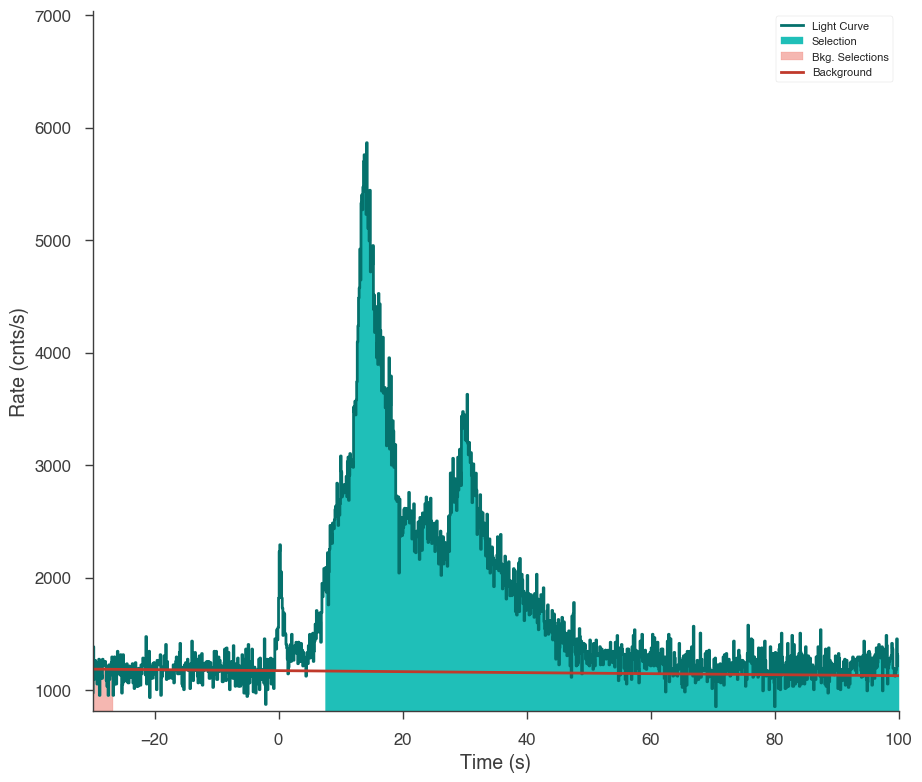

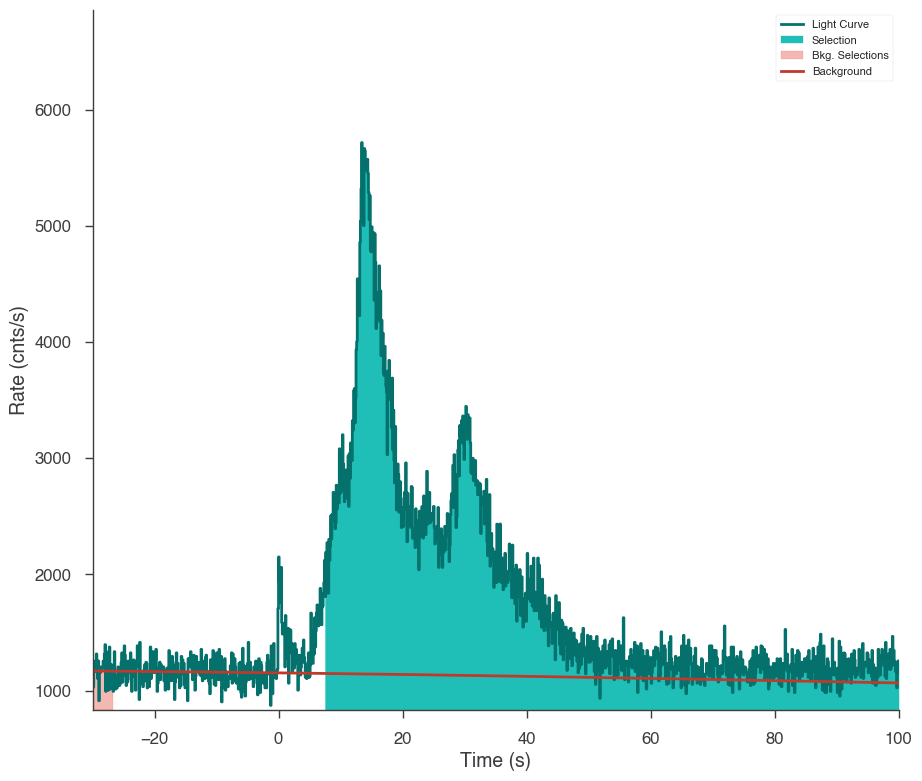

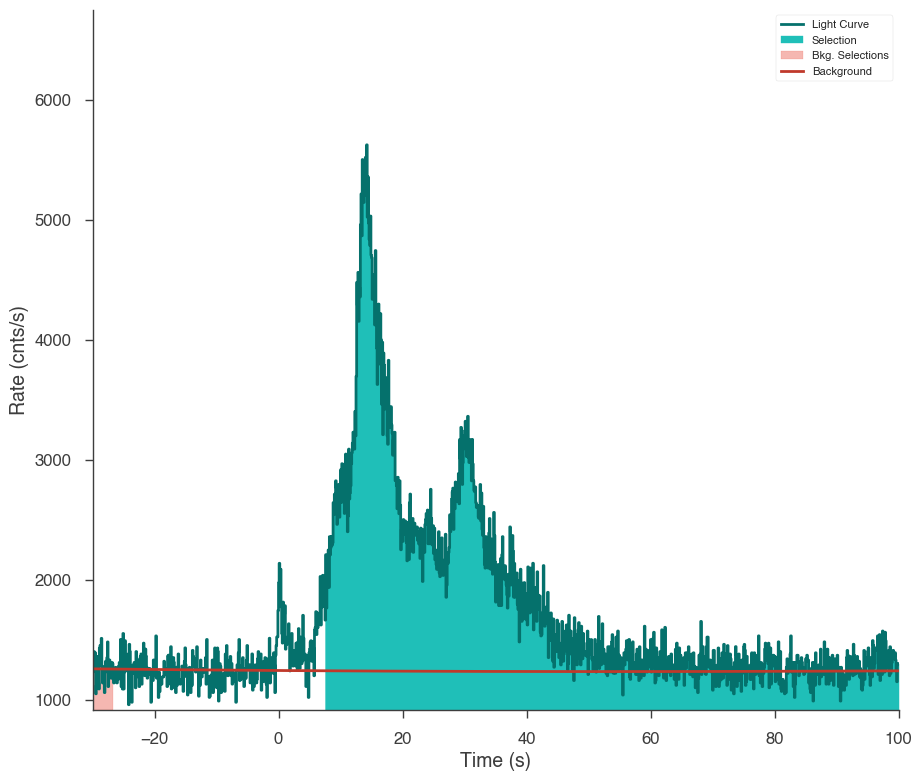

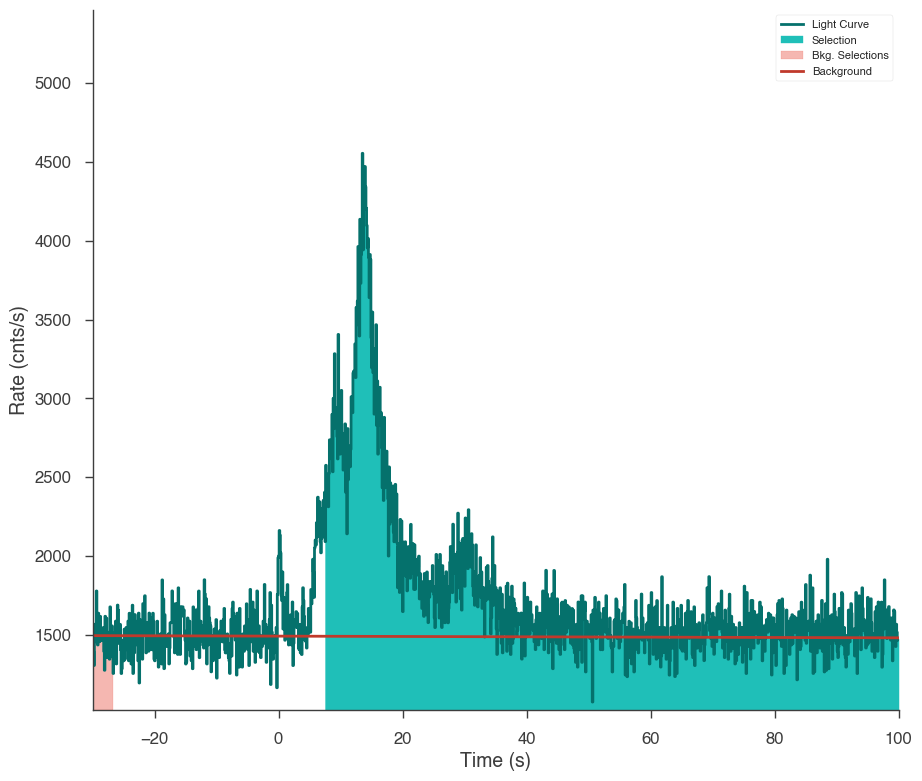

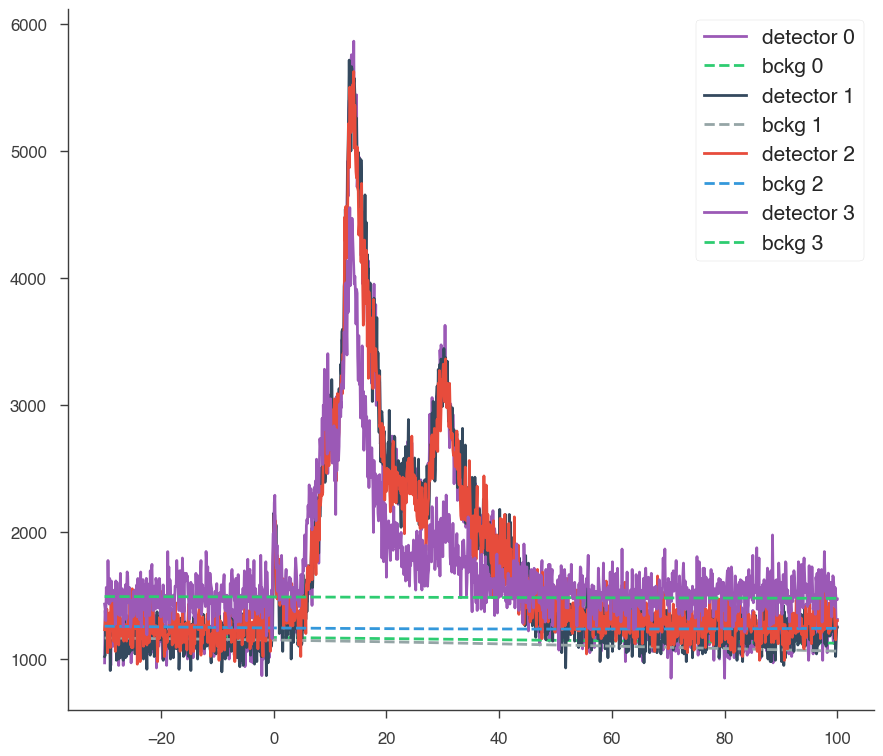

In [40]:
figures = query_catalog(GRBNAME = '140206275', time_in = -30, time_out = 100,dt=.1)

data, time_domain = retrieve_data(figures)
fig = show_curves(figures)
fig.show()

In [41]:
def prior_transform_14(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3
    hi = 1e5
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

Peak index at 439
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+03  899.88 [-1900.2733..-1900.2719]*| it/evals=17600/282066 eff=6.2485% N=400    00 0 
[ultranest] Likelihood function evaluations: 282136
[ultranest]   logZ = -1940 +- 0.2027
[ultranest] Effective samples strategy satisfied (ESS = 2494.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.16 to 0.51, need <0.5)
[ultranest]   logZ error budget: single: 0.30 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.

logZ = -1939.631 +- 0.507
  single instance: logZ = -1939.631 +- 0.303
  bootstrapped   : logZ = -1939.638 +- 0.507
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    K_lightcurve        : 1483  │ ▁▁▁▁▁▁▁▁▂▂▃▃▄▅▇▇▇▇▇▆▆▅▄▃▂▂▁▁▁▁▁▁▁▁  ▁ │2521      1970 +- 122
    K_powerlaw          : 3308  │ ▁▁ ▁▁▁▁▁▁▁▁▂▂▃▃▅▆▆▆▇▆▅▆▄▃▃▂▁▁▁▁▁▁▁▁▁▁ │3640     

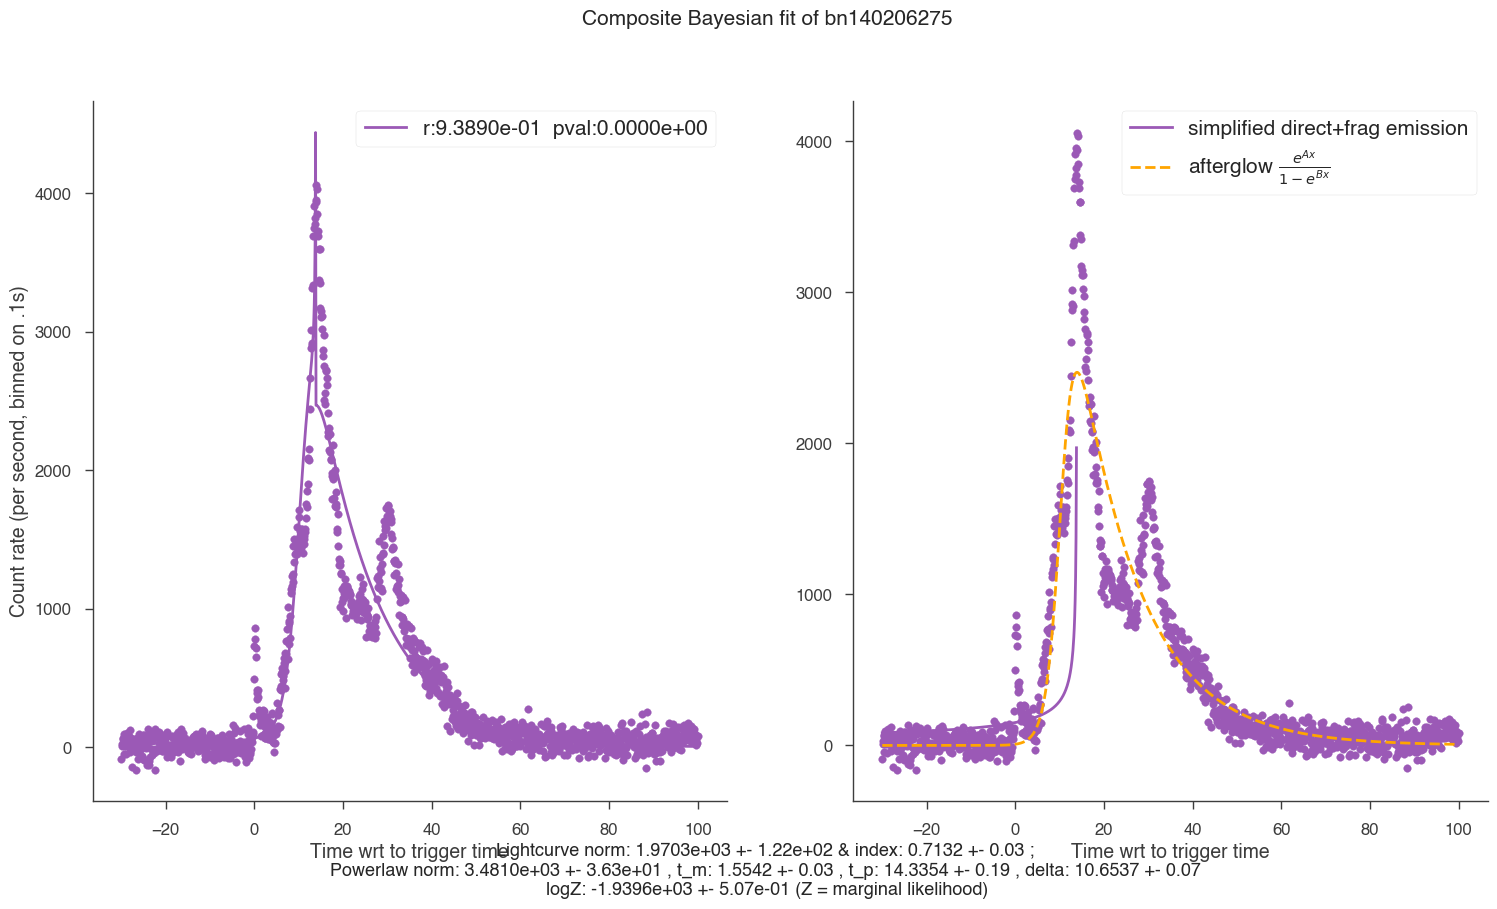

In [43]:
bckg_data=[]
for fig in figures:
    _,_, b = get_curves(fig)
    bckg_data.append(b)
error_tolerance = np.std(bckg_data)

peak_index = np.where(data == max(data))[0][0]
print('Peak index at %s'%peak_index)

sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_transform_14)

result14 = sampler.run()
sampler.print_results()

fig = plot_model(time_domain, result = result14, log=False, name = 'bn140206275')

[back to candidates](#candidates)

#### <a id="15" style="color:black;">bn150118409</a>

- tau = [ -20 , 70 ]

- K_lightcurve = [ 1e3 , 1e5 ]
- K_powerlaw = [ 1 , 1e4 ]

In [ ]:
def prior_transform_15(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3
    hi = 1e5
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

[back to candidates](#candidates)

#### <a id="16" style="color:black;">bn160821857</a>

- tau = [ -20 , 40 ]

- K_lightcurve = [ 1e3 , 1e7 ]
- K_powerlaw = [ 1 , 1e6 ]

In [ ]:
figures = query_catalog(GRBNAME = '160821857', time_in = 100, time_out = 200,dt=.1)

data, time_domain = retrieve_data(figures)
fig = show_curves(figures)
fig.show()

In [25]:
def prior_transform_16(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 5*1e3
    hi = 1e6
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e5
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = 100
    hi = 180
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

Peak index at 357
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+03  352.07 [-1352.5601..-1352.5600]*| it/evals=20120/1321167 eff=1.5234% N=400   0   0  0 
[ultranest] Likelihood function evaluations: 1321182
[ultranest]   logZ = -1398 +- 0.245
[ultranest] Effective samples strategy satisfied (ESS = 2743.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.19 to 0.54, need <0.5)
[ultranest]   logZ error budget: single: 0.33 bs:0.24 tail:0.01 total:0.25 required:<0.50
[ultranest] done iterating.

logZ = -1398.111 +- 0.542
  single instance: logZ = -1398.111 +- 0.326
  bootstrapped   : logZ = -1398.123 +- 0.542
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    K_lightcurve        : 5000  │▇▆▅▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁  ▁ │5451      5050 +- 48
    K_powerlaw          : 19790 │ ▁▁ ▁▁▁▁▁▁▁▂▂▃▄▄▅▇▇▇▇▇▇▆▅▄▃▃▂▁▁▁▁▁▁▁▁▁ │20693 

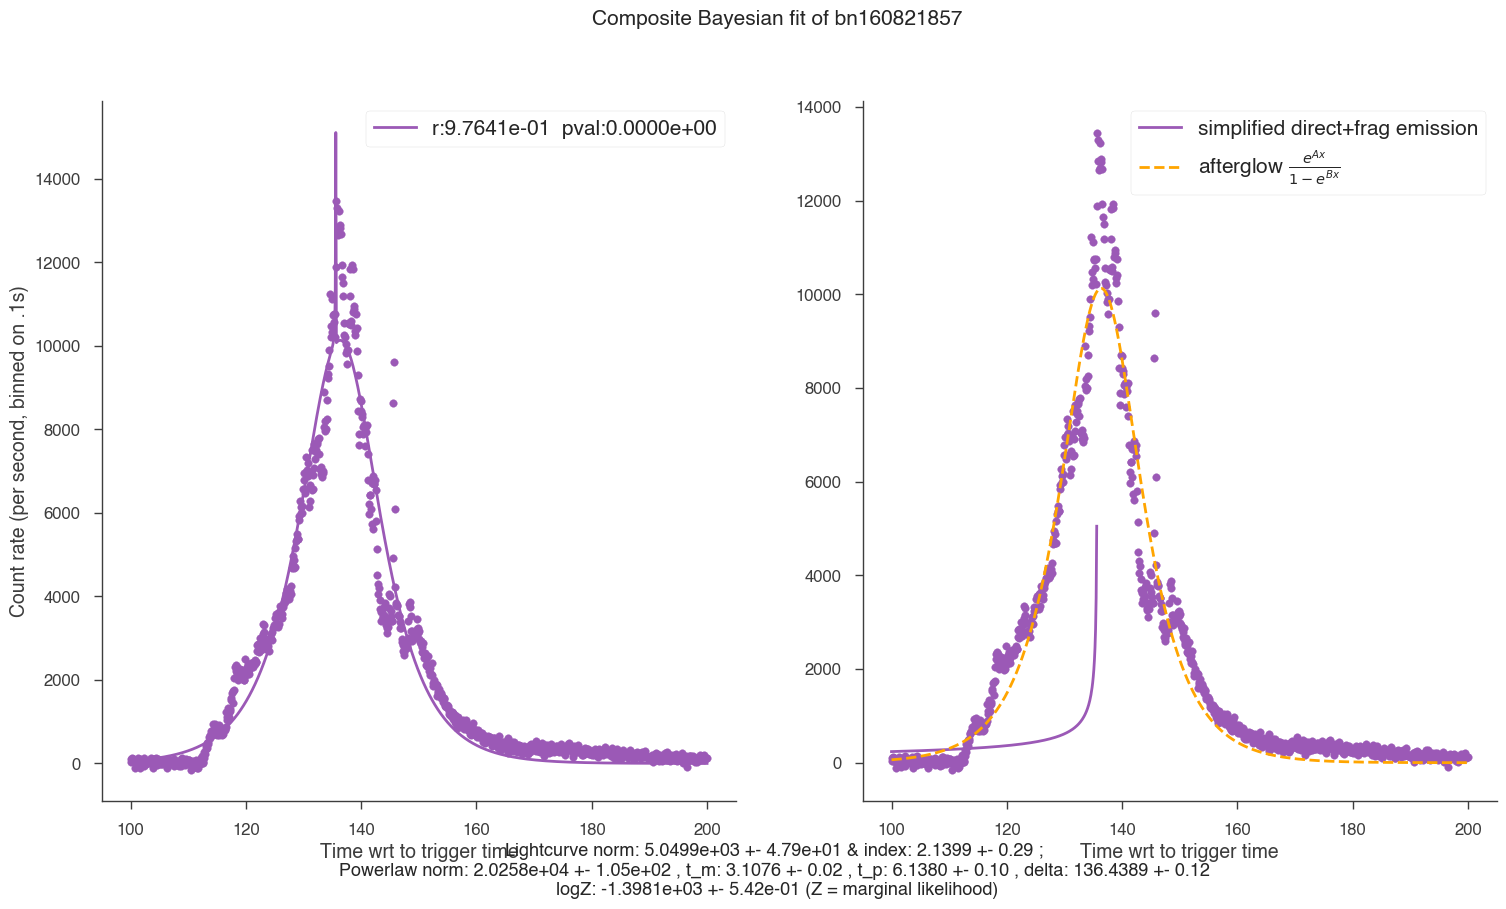

In [33]:
bckg_data=[]
for fig in figures:
    _,_, b = get_curves(fig)
    bckg_data.append(b)
error_tolerance = np.std(bckg_data)

peak_index = np.where(data == max(data))[0][0]
print('Peak index at %s'%peak_index)

sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_transform_16)

result16 = sampler.run()
sampler.print_results()

fig = plot_model(time_domain, result = result16, log=False, name = 'bn160821857')

[back to candidates](#candidates)

#### <a id="18" style="color:black;">bn180718763</a>

- tau = [ -20 , 40 ]

- K_lightcurve = [ 10 , 1e5 ]
- K_powerlaw = [ 1 , 1e4 ]

In [ ]:
def prior_transform_18(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3
    hi = 1e7
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e6
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

[back to candidates](#candidates)

#### <a id="19" style="color:black;">bn190731943</a>

- tau = [ -20 , 40 ]

- K_lightcurve = [ 10 , 1e5 ]
- K_powerlaw = [ 1 , 1e4 ]

['n6', 'n7', 'n8', 'n9', 'na', 'nb', 'b1']


19:59:06 INFO      file glg_cspec_n6_bn190731943_v00.pha is already downloaded!           ]8;id=666209;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=572643;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

19:59:07 INFO      file glg_cspec_n6_bn190731943_v02.rsp2 is already downloaded!          ]8;id=591674;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=837856;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n6_bn190731943_v00.fit is already downloaded!             ]8;id=878168;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=382870;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

19:59:08 INFO      file glg_cspec_n7_bn190731943_v00.pha is already downloaded!           ]8;id=585214;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=869238;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n7_bn190731943_v02.rsp2 is already downloaded!          ]8;id=529963;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=821688;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_tte_n7_bn190731943_v00.fit is already downloaded!             ]8;id=956811;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=808684;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

19:59:09 INFO      file glg_cspec_n8_bn190731943_v00.pha is already downloaded!           ]8;id=505566;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=357430;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n8_bn190731943_v02.rsp2 is already downloaded!          ]8;id=264341;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=846744;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:00:40 INFO      Auto-determined polynomial order: 0                                ]8;id=555291;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=194057;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_06 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:00:52 INFO      None 0-order polynomial fit with the mle method                               ]8;id=401438;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=982543;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n6_bkg.h5                                         ]8;id=573091;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=259274;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

20:00:53 INFO      Saved background to n6_bkg.h5                                         ]8;id=408226;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=57128;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n6_bkg.h5                              ]8;id=66976;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=394933;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.792-17.664 for n6                                   ]8;id=393246;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=625908;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:00:57 INFO      Auto-determined polynomial order: 0                                ]8;id=880850;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=806789;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_07 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:01:10 INFO      None 0-order polynomial fit with the mle method                               ]8;id=68267;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=272444;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n7_bkg.h5                                         ]8;id=655256;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=450752;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n7_bkg.h5                                         ]8;id=182190;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=934474;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n7_bkg.h5                              ]8;id=465465;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=681041;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

20:01:11 INFO      Interval set to 1.792-17.664 for n7                                   ]8;id=916731;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=337867;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:01:16 INFO      Auto-determined polynomial order: 0                                ]8;id=711435;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=658853;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_08 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:01:29 INFO      None 0-order polynomial fit with the mle method                               ]8;id=566460;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=239548;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n8_bkg.h5                                         ]8;id=22173;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=910690;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n8_bkg.h5                                         ]8;id=238365;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=761162;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n8_bkg.h5                              ]8;id=147109;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=180948;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

20:01:30 INFO      Interval set to 1.792-17.664 for n8                                   ]8;id=946942;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=653560;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:01:33 INFO      Auto-determined polynomial order: 0                                ]8;id=489814;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=768930;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_09 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:01:45 INFO      None 0-order polynomial fit with the mle method                               ]8;id=926462;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=321912;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n9_bkg.h5                                         ]8;id=489938;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=305729;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n9_bkg.h5                                         ]8;id=903578;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=762200;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

20:01:46 INFO      Successfully restored fit from n9_bkg.h5                              ]8;id=839097;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=456413;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.792-17.664 for n9                                   ]8;id=443775;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=203400;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:01:49 INFO      Auto-determined polynomial order: 0                                ]8;id=558612;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=671965;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_10 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:02:01 INFO      None 0-order polynomial fit with the mle method                               ]8;id=651970;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=36506;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to na_bkg.h5                                         ]8;id=981567;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=493756;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to na_bkg.h5                                         ]8;id=489509;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=353555;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from na_bkg.h5                              ]8;id=808418;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=484124;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

20:02:02 INFO      Interval set to 1.792-17.664 for na                                   ]8;id=883110;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=484948;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:02:06 INFO      Auto-determined polynomial order: 0                                ]8;id=329440;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=228667;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_11 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:02:19 INFO      None 0-order polynomial fit with the mle method                               ]8;id=668688;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=451285;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to nb_bkg.h5                                         ]8;id=275833;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=768305;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to nb_bkg.h5                                         ]8;id=814385;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=338382;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from nb_bkg.h5                              ]8;id=135183;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=243637;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.792-17.664 for nb                                   ]8;id=71020;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=567824;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

Loading PHAII Spectra:   0%|                           | 0/2394 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

20:02:24 INFO      Auto-determined polynomial order: 0                                ]8;id=633602;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=442250;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_BGO_01 background:   0%|                    | 0/128 [00:00<?, ?it/s]

20:02:38 INFO      None 0-order polynomial fit with the mle method                               ]8;id=195374;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=157112;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to b1_bkg.h5                                         ]8;id=143130;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=319279;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b1_bkg.h5                                         ]8;id=833228;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=942576;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

20:02:39 INFO      Successfully restored fit from b1_bkg.h5                              ]8;id=118927;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=780516;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.792-17.664 for b1                                   ]8;id=549120;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=307809;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

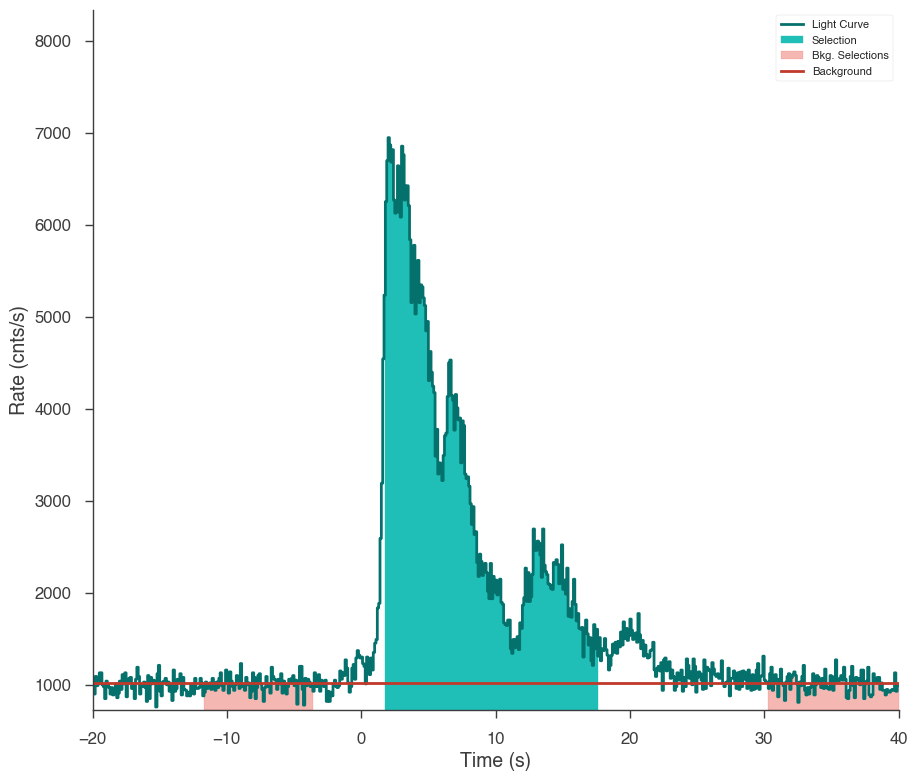

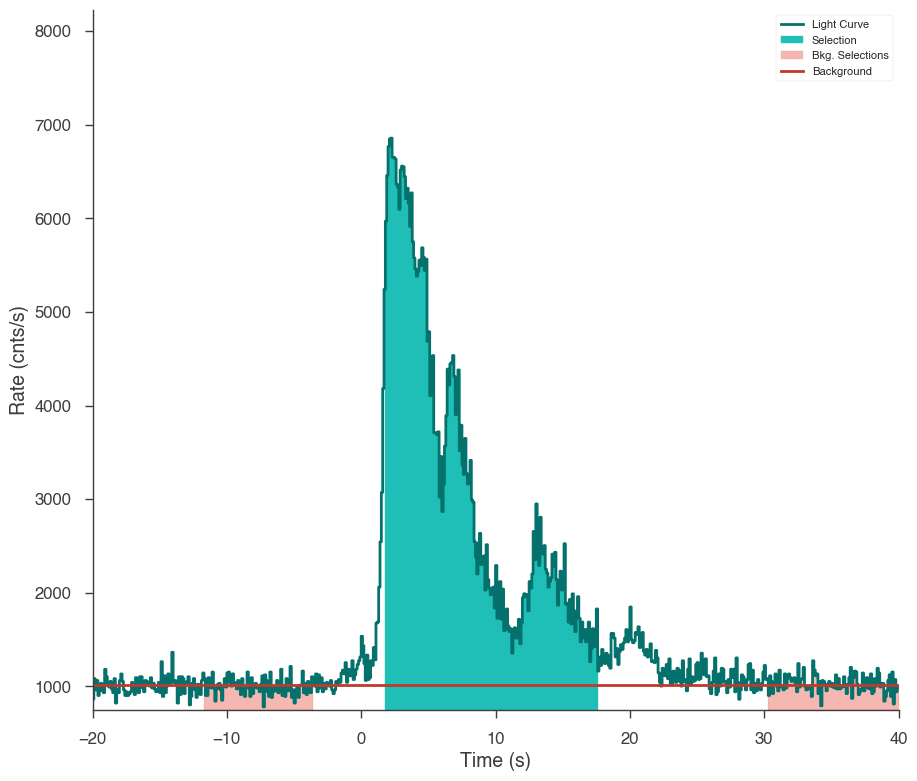

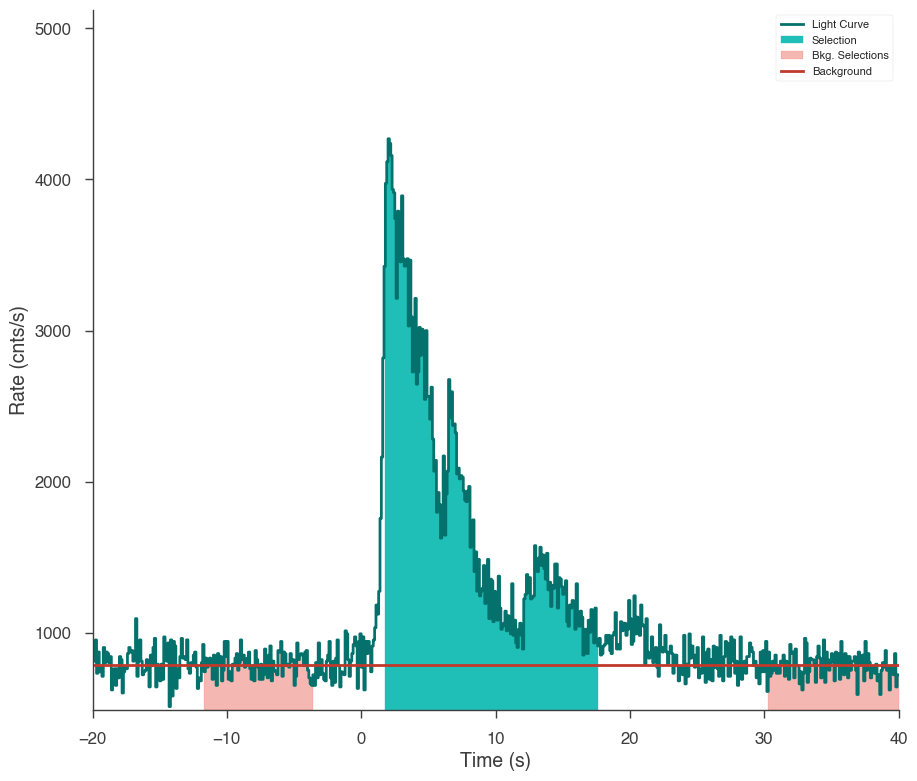

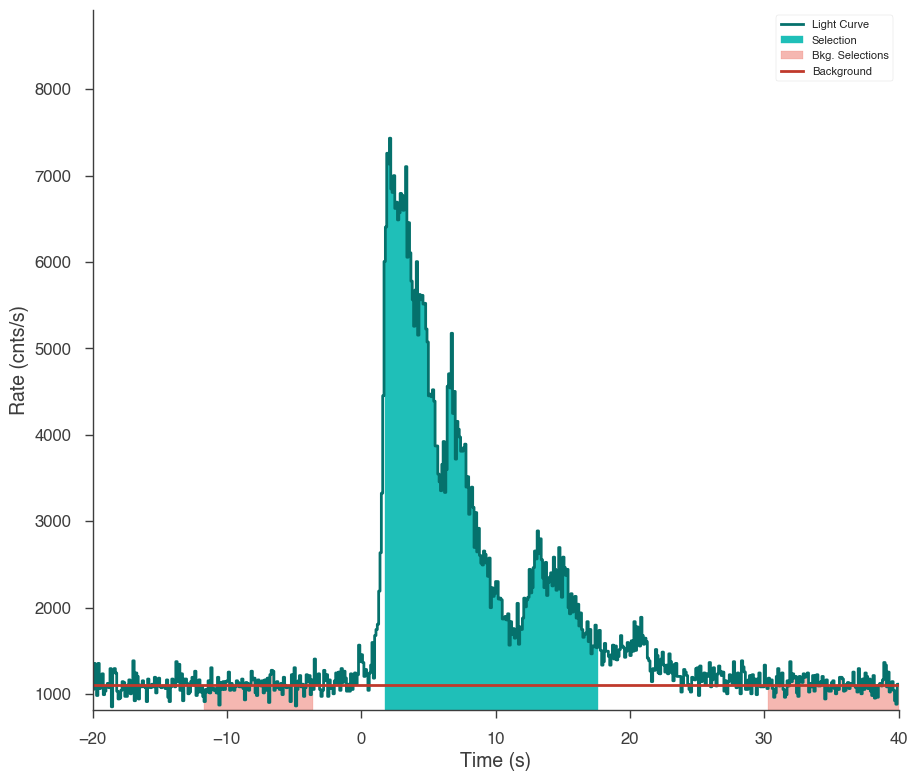

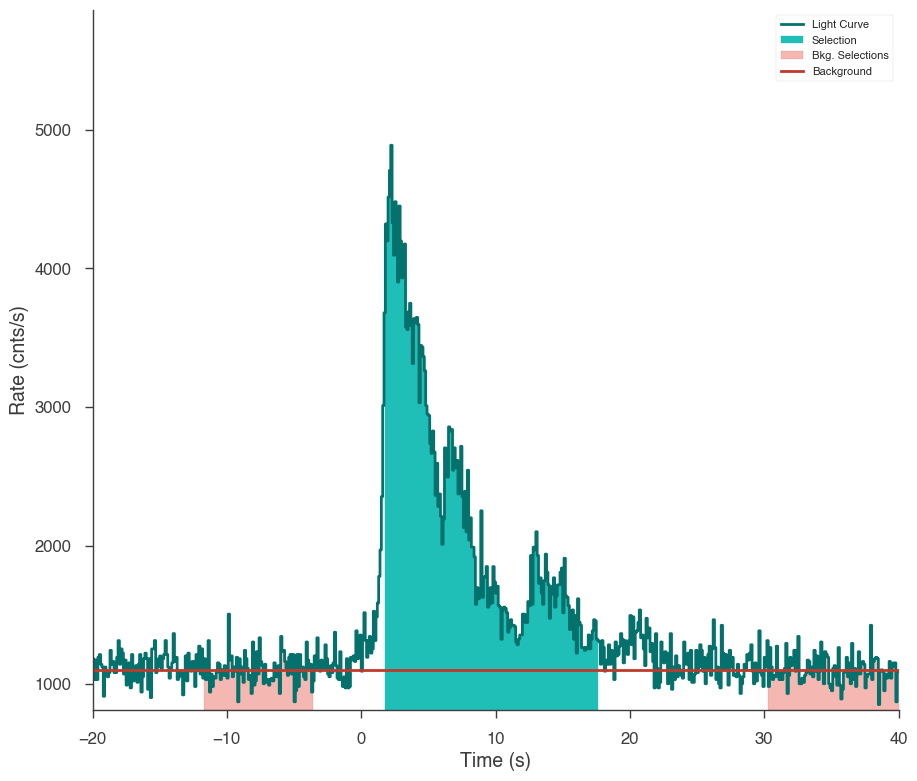

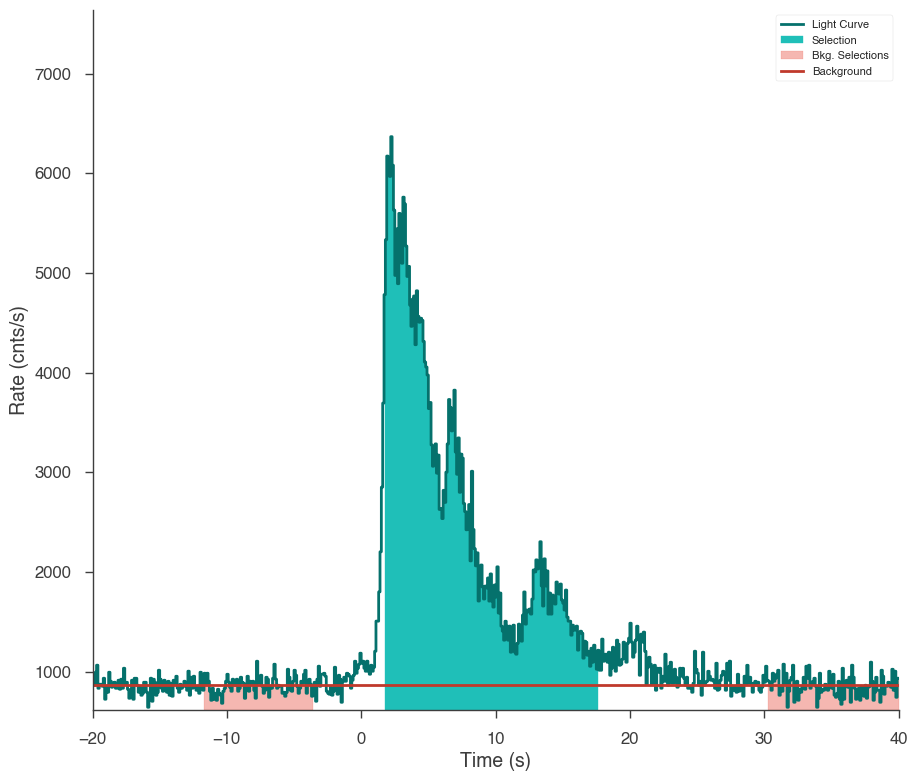

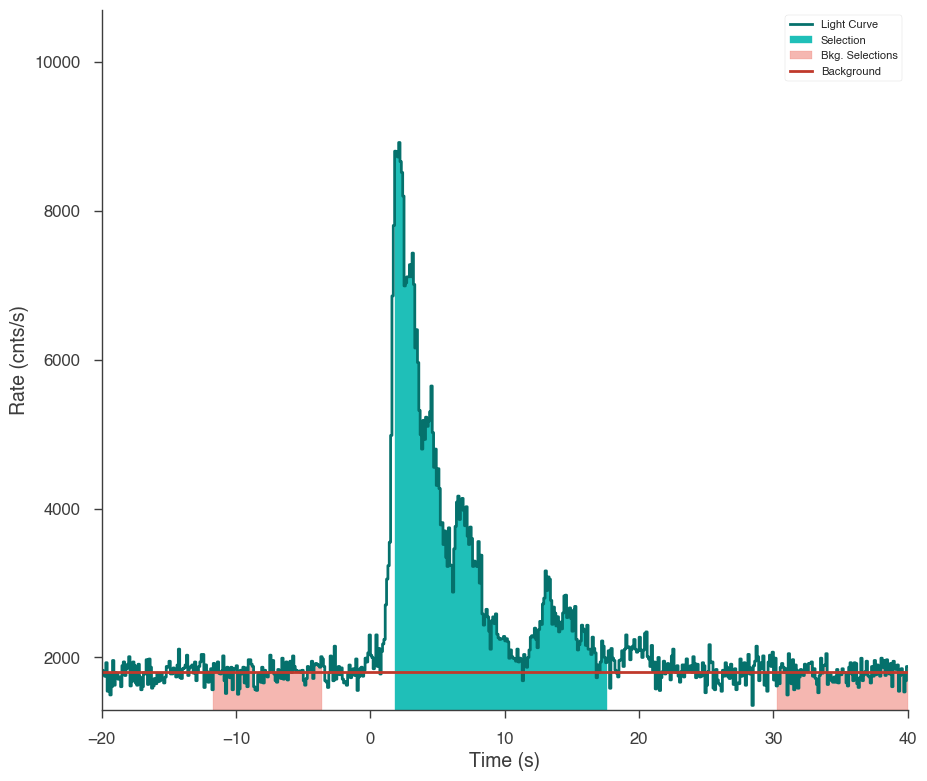

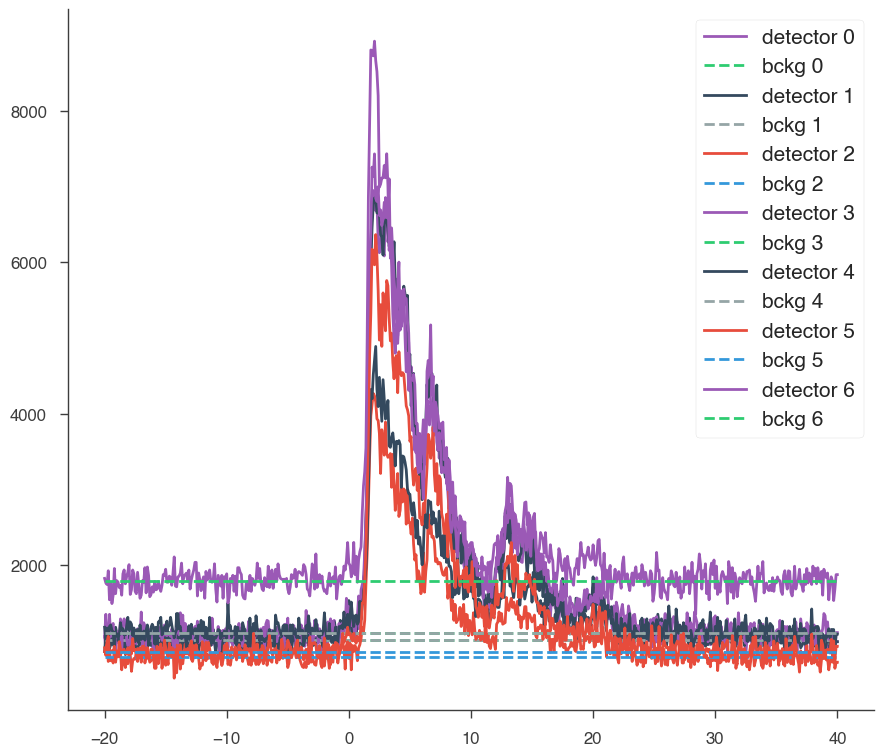

In [35]:
figures = query_catalog(GRBNAME = '190731943', time_in = -20, time_out = 40,dt=.1, gbm_detectors = ['n6', 'n7', 'n8', 'n9', 'na', 'nb', 'b1'])

data, time_domain = retrieve_data(figures)
fig = show_curves(figures)
fig.show()

In [26]:
def prior_transform_19(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3
    hi = 1e5
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

In [38]:
bckg_data=[]
for fig in figures:
    _,_, b = get_curves(fig)
    bckg_data.append(b)
error_tolerance = np.std(bckg_data)

peak_index = np.where(data == max(data))[0][0]
print('Peak index at %s'%peak_index)

sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_transform_19)

result19 = sampler.run()
sampler.print_results()

Peak index at 221
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+02  .83 [-141.3571..-141.3558]*| it/evals=17600/470757 eff=3.7418% N=400    00 0 
[ultranest] Likelihood function evaluations: 470866
[ultranest]   logZ = -180.6 +- 0.1965
[ultranest] Effective samples strategy satisfied (ESS = 2586.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.20, need <0.5)
[ultranest]   logZ error budget: single: 0.30 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.

logZ = -180.653 +- 0.460
  single instance: logZ = -180.653 +- 0.302
  bootstrapped   : logZ = -180.648 +- 0.460
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    K_lightcurve        : 1000  │▇▆▅▅▄▃▃▃▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁  ▁ │1962      1130 +- 117
    K_powerlaw          : 5464  │ ▁ ▁▁▁▁▁▁▁▁▂▃▄▅▅▆▆▇▇▇▆▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁ │6355      5902 +- 101
    t_m_powerlaw        

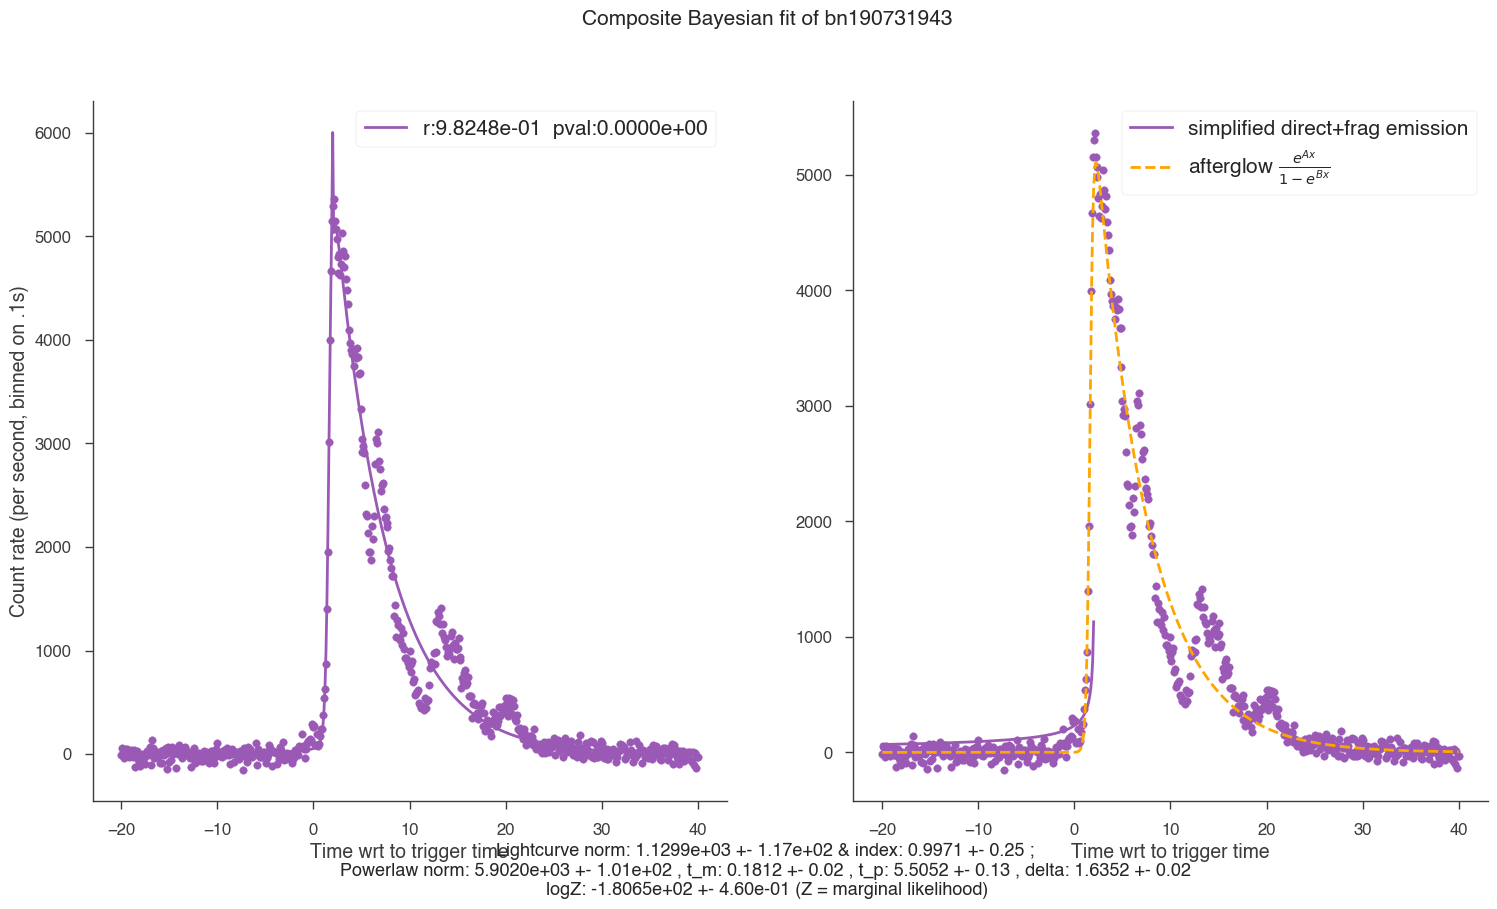

In [39]:
fig = plot_model(time_domain, result = result19, log=False, name='bn190731943'

Miscellaneous possible candidates

- 180305393 (Weirdly high error)

- 131216081
- 121225417
- 150416773
- 160101215

Top short burst duration

- 090531775
- 130310840
- 160325291

S-bursts
- bn110728056
- bn141113346
- bn090228204 : time_in=-.5, time_out=1

['n9']


03:32:06 INFO      file glg_cspec_n9_bn130310840_v00.pha is already downloaded!           ]8;id=546077;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=302225;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n9_bn130310840_v03.rsp is already downloaded!           ]8;id=822513;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=171863;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

03:32:07 INFO      file glg_tte_n9_bn130310840_v00.fit is already downloaded!             ]8;id=977921;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=676357;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/1854 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

03:32:10 INFO      Auto-determined polynomial order: 0                                ]8;id=799622;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=317703;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_09 background:   0%|                    | 0/128 [00:00<?, ?it/s]

03:32:22 INFO      None 0-order polynomial fit with the mle method                               ]8;id=236388;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=20192;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n9_bkg.h5                                         ]8;id=688154;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=534488;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n9_bkg.h5                                         ]8;id=582310;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=248407;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n9_bkg.h5                              ]8;id=476640;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=425196;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 4.096-20.096 for n9                                   ]8;id=974628;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=768039;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

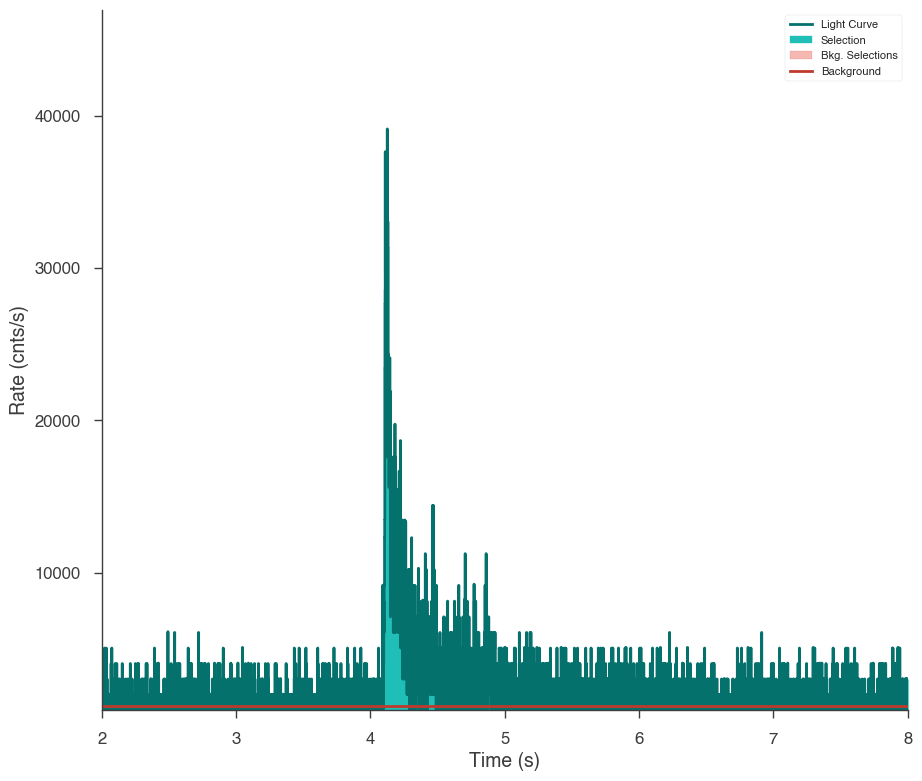

In [14]:
GRBNAME = '130310840'

figures = query_catalog(GRBNAME = GRBNAME, 
                        time_in = 2, time_out = 8, dt=1e-3,
                        gbm_detectors = ['n9'])

Text(0.5, 0, 's')

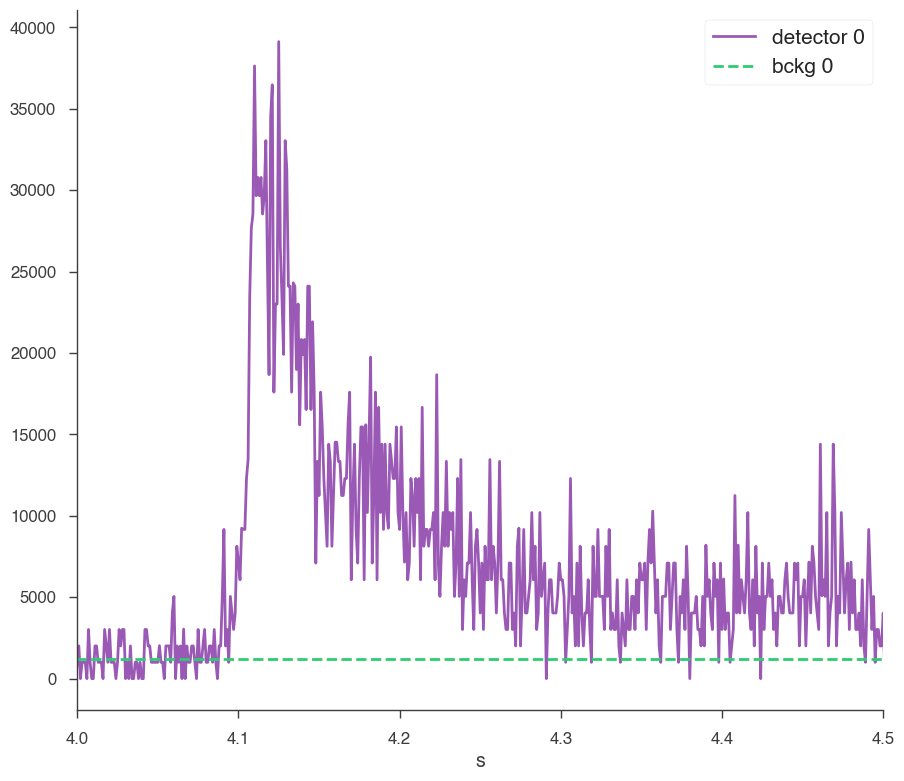

In [15]:
fig = show_curves(figures)
ax = fig.get_axes()[0]
ax.set_xlim(4,4.5)
ax.set_xlabel('s')
# Looks quite similar to Figure 5 in the Cline '97 paper

In [33]:
def prior_transform_13(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3
    hi = 1e5
    params[0] = cube[0] * (hi - lo) + lo
    """
    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    """
    # index_lightcurve: gaussian on -.52 
    params[1] = norm.ppf(cube[1], -.52, 1)
    
    return params

data, time_domain = retrieve_data(figures)

In [34]:
bckg_data=[]
for fig in figures:
    _,_, b = get_curves(fig)
    bckg_data.append(b)
error_tolerance = 1e2#np.std(bckg_data)
print('Using error tolerance of %3e'%error_tolerance)

peak_index = np.where(data == max(data))[0][0]
print('Peak index at %s'%peak_index)

sampler = ultranest.ReactiveNestedSampler([param_names[0], param_names[-1]],
                                          likelihood_model_only_direct, prior_transform_13)

result19 = sampler.run()
sampler.print_results()

Using error tolerance of 1.000000e+02
Peak index at 2125
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+06  91..-2297783.90 [-2297783.9135..-2297783.9135]*| it/evals=7840/10603 eff=76.8401% N=400 
[ultranest] Likelihood function evaluations: 10617
[ultranest]   logZ = -2.298e+06 +- 0.1394
[ultranest] Effective samples strategy satisfied (ESS = 1590.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.

logZ = -2297798.935 +- 0.342
  single instance: logZ = -2297798.935 +- 0.187
  bootstrapped   : logZ = -2297798.947 +- 0.342
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    K_lightcurve        : 47352 │ ▁▁▁▁▁▁▁▁▂▃▃▄▆▅▅▆▆▇▇▆▅▅▃▃▂▁▂▁▁▁▁▁▁▁▁ ▁ │47913     47610 +- 70
    index_lightcurve    : 0.69056│ ▁▁▁▁▁▁▁▁▁▂▂▂▃▄▆▅▆▇▇▇▇▆▇▅▄▄▂▂▂▁▁▁▁▁▁▁▁ │0.69469    0.69272 

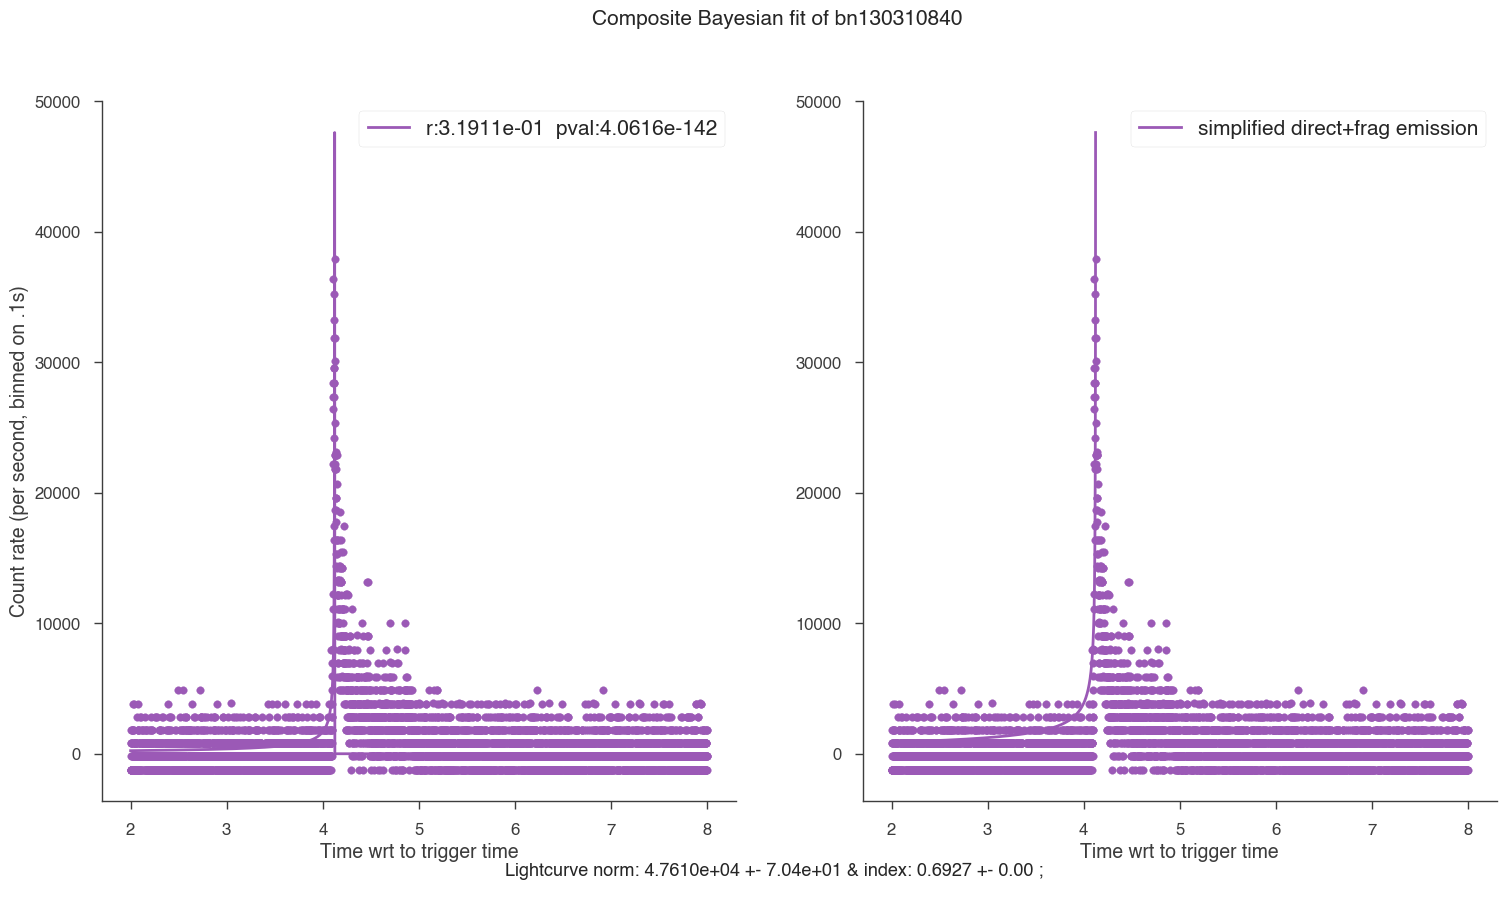

In [52]:
v = result19['posterior']['mean']
s = result19['posterior']['stdev']
fig = plot_model(time_domain, vals = [v[0], None, None, None, None, v[1]], log=False, name='bn130310840',
                fig_text = "Lightcurve norm: %.4e +- %.2e & index: %.4f +- %.2f ; \n"%(v[0], s[0], v[1], s[1]))


### <a id="batchfit2s" style="color:black;">Batch fit all sources with a GBM or LLE t90<2s </a>
[back to top](#Top)

In [26]:
selection = pd.read_csv('./GBM_Catalog_Searching/Single_bin_<2s_sources.csv')

cols = ['name', 'lle_t90', 'gbm_cat_t90', 'hardness', 'gbm-lle_t90_difference', 'like_gbm-lat_time_difference']

selection[cols].sort_values(by='gbm-lle_t90_difference')

,name,lle_t90,gbm_cat_t90,hardness,gbm-lle_t90_difference,like_gbm-lat_time_difference
26,GRB090227772,1.144,0.304,0.000000,-0.840,-0.01600
19,GRB190606080,0.101,0.224,inf,0.123,-31.60000
0,GRB170127067,0.000,0.128,inf,0.128,-664.76001
12,GRB200415367,0.000,0.144,inf,0.144,-19.18000
29,GRB110529034,0.093,0.512,0.000000,0.419,-0.12800
10,GRB090228204,0.000,0.448,1.026812,0.448,-0.09000
9,GRB120830297,0.000,0.896,2.852463,0.896,-0.66000
1,GRB200219317,0.213,1.152,NaN,0.939,0.00000
13,GRB131014215,1.811,3.200,1.224058,1.389,-0.89000
3,GRB141222298,1.293,2.752,inf,1.459,-34.21000


In [11]:
# For each selection, we need to query source at high resolution from t05 to t95
#     - can be done by seeing what 3ML chooses, or could just go off the GBM Cat data
# Fit just the direct curve
# Save the fitted image
# Record the plaw index in the selection csv

save_directory = './Completed_fits/Batch_SGRBs'

param_names = ['K_lightcurve', 'index_lightcurve']
def prior_transform(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e2
    hi = 1e6
    params[0] = cube[0] * (hi - lo) + lo

    # index_lightcurve: gaussian on -.52 
    params[1] = norm.ppf(cube[1], -.52, 1)
    
    return params

def run():
    saved_vals = {'index':[], 'index_std':[], 'normalization':[], 'normalization_std':[]}

    for i in range(len(selection)):

        # Just trim the bn number out
        GRBNAME = selection.iloc[i]['name'][3:12]
        print('\nStarting %s, %s/%s'%(GRBNAME, i+1, len(selection)))

        gbm_cat_t05 = -1#selection.iloc[i]['gbm_cat_t05']-.5
        gbm_cat_t95 = 3#selection.iloc[i]['gbm_cat_t95']

        try:
            # Retrieve binning
            figures = query_catalog(GRBNAME = GRBNAME, 
                                    time_in = gbm_cat_t05, time_out = gbm_cat_t95, dt=1e-3)
            # Extract data
            data, time_domain = retrieve_data(figures)

            # Change this to std of background 
            error_tolerance = np.mean(data)*.01
            print('Using error tolerance of %3e'%error_tolerance)

            peak_index = np.where(data == max(data))[0][0]
            print('Peak index at %s'%peak_index)

            sampler = ultranest.ReactiveNestedSampler([param_names[0], param_names[-1]],
                                              likelihood_model_only_direct, prior_transform)

            result = sampler.run()
            sampler.print_results()

            #result.to_csv('%s/bn%s.csv'%(save_directory, GRBNAME))

            v = result['posterior']['mean']
            s = result['posterior']['stdev']

            saved_vals['index'].append( v[1] )
            saved_vals['normalization'].append( v[0] )
            saved_vals['index_std'].append( s[1] )
            saved_vals['normalization_std'].append( s[0] )

            fig = plot_model(time_domain, vals = [v[0], None, None, None, None, v[1]], log=False, 
                             name='bn%s'%GRBNAME,
                             fig_text = "Lightcurve norm: %.4e +- %.2e & index: %.4f +- %.2f ; \n"%(v[0], s[0], v[1], s[1]))

            fig.savefig('%s/bn%s.png'%(save_directory, GRBNAME))

        except Exception as e: 
            print('Skipping %s, it threw exception\n%s'%(GRBNAME , e))
            continue

    
    
    
    

In [50]:
df = pd.read_csv('./../GBM_Catalog_Searching/H>1_T90[0.2-5]_RS=0.csv')



save_directory = './Lighcurves_of_selected_GRBs/'
def download_lightcurves():
    df['successful'] = False
    for i in range(0,len(df)):
        try:
            name = df.iloc[i]['name'][3:]
            t_i = df.iloc[i]['time_in']
            t_o = df.iloc[i]['time_out']
            print('Trying GRB%s on %s to %s'%(name, t_i, t_o))
            
            figures, dets = query_catalog(GRBNAME = name, time_in = t_i, time_out = t_o, dt = 1e-3)
            fig = show_curves(figures, detectors = dets, 
                              save_csv = '%sGRB%s_%s_to_%s.csv'%(save_directory, name, t_i, t_o))
            fig.savefig('%sGRB%s_%s_to_%s.png'%(save_directory, name, t_i, t_o), dpi=200)
            
            df.iloc[i]['successful']=True
        except Exception as e:
            print('Failed with %s'%df.iloc[i]['name'])
            print('%s\n'%e)
            
#download_lightcurves()

----

Generating spectrum for the sources with HS>1, gbm AND lle t90 in (0.2,5) and RS=0

[SpectrumLike spectrum gen](https://threeml.readthedocs.io/en/stable/notebooks/spectrum_tutorial.html)

In [55]:
df = pd.read_csv('./../GBM_Catalog_Searching/BOTH_T90_in_[0.2-5].csv')
df

,Unnamed: 0,name,ra,dec,hardness,lle_t90,gbm_cat_t90,gbm-lle_t90_difference
0,25,GRB141222298,178.00,-57.31,inf,1.293,2.752,1.459
1,85,GRB131014215,100.78,-20.76,1.224058,1.811,3.200,1.389
2,100,GRB140619475,132.66,-9.65,1.339559,1.124,2.816,1.692
3,121,GRB140102887,212.02,1.47,1.319773,2.872,3.648,0.776
4,131,GRB140402007,207.66,5.97,9.669260,1.546,0.320,-1.226
5,155,GRB081024891,323.01,20.84,1.916036,1.320,0.640,-0.680
6,168,GRB190515190,137.75,28.93,1.454990,1.645,1.264,-0.381


In [82]:
location='./Selected_GRB_Images/Spectra/'

def generate_spectrum(GRBNAME):
    gbm_catalog.query_sources(GRBNAME)

    grb_info = gbm_catalog.get_detector_information()[GRBNAME]

    gbm_detectors = grb_info["detectors"]
    if len(gbm_detectors) < 1:
        gbm_detectors = ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'na','nb', 'b0', 'b1']
    print(gbm_detectors)
    
    source_interval = grb_info["source"]["fluence"]
    background_interval = grb_info["background"]["full"]
    #best_fit_model = grb_info["best fit model"]["fluence"]
    #model = gbm_catalog.get_model(best_fit_model, "fluence")[GRBNAME]

    dload = download_GBM_trigger_data('bn%s'%GRBNAME[3:], detectors=gbm_detectors)

    figs = []
    #fluence_plugins = []
    time_series = {}
    figures = []
    for det in gbm_detectors:

        ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
            det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
        )

        ts_cspec.set_background_interval(*background_interval.split(","))
        ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

        ts_tte = TimeSeriesBuilder.from_gbm_tte(
            det,
            tte_file=dload[det]["tte"],
            rsp_file=dload[det]["rsp"],
            restore_background=f"{det}_bkg.h5",
        )

        time_series[det] = ts_tte

        ts_tte.set_active_time_interval(source_interval)

        #figures.append(ts_tte.view_lightcurve(-40, 100))

        fluence_plugin = ts_tte.to_spectrumlike()

        if det.startswith("b"):

            fluence_plugin.set_active_measurements("250-30000")

        else:

            fluence_plugin.set_active_measurements("9-900")

        fluence_plugin.rebin_on_background(1.0)

        fig = fluence_plugin.view_count_spectrum()
        fig.suptitle('%s Detector %s'%(GRBNAME, det))
        
        fig.savefig('%s%s_det_%s'%(location, GRBNAME, det))

        figs.append( fig )

        #fluence_plugins.append(fluence_plugin)

In [ ]:
for name in ["GRB190515190"]:#df['name']:
    try:
        generate_spectrum(name)
    except Exception as e:
        print('Failed with %s\n%s'%(name, e))

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'na', 'nb', 'b0', 'b1']
